# Implementing the Domain Transfer feature for eval.py

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np

import path
from modules.model import Rotated_cINN
from modules.data import RotatedMNIST as R
import torchvision.transforms.functional as TF

In [2]:
device = 'cuda'  if torch.cuda.is_available() else  'cpu'


# Loading the dataset
dataset_name = "eval_og_mnist"
dataset_path = path.package_directory + "/datasets"

dataset = torch.load(f"{dataset_path}/test_{dataset_name}.pt")


# Loading the model
model_name = "recreation_with_domains"
model_path = path.package_directory + f"/tested_models/{model_name}.pt"

cinn = Rotated_cINN().to(device)
state_dict = {k:v for k,v in torch.load(model_path).items() if 'tmp_var' not in k}
cinn.load_state_dict(state_dict)
cinn.eval();

In [3]:
data, targets, domain_labels, class_labels = dataset[:100]


In [4]:
def domain_transfer(model:Rotated_cINN, data:torch.Tensor, targets:torch.Tensor, angles:list):
    """
    Arguments
    ---------
    model : Rotated_cINN
    data : torch.Tensor, shape=(N, H, W)
    targets: torch.Tensor, shape=(N, 12)
    angles : list, dtype= int or float, shape=(N)

    N = number of angles
    H, W = height and width of image

    Returns
    -------
    data_rotated : torch.Tensor, shape=(N, H, W)
    data_reconstructed : torch.Tensor, shape=(N, H, W)
    """

    data_rotated = R.rotate(data, angles)
    targets_rotated = torch.cat([R.deg2cossin(angles), targets[:, 2:]], dim=1)
    latent_vectors = model.forward(R._normalize(data), targets)[0]
    data_reconstructed = R._unnormalize(model.reverse(latent_vectors, targets_rotated)[0].squeeze())

    return data_rotated, data_reconstructed

In [116]:
def plot_transfer_image(rotated:torch.Tensor, reconstructed:torch, angles):
    """
    Arguments
    ---------
    data_rotated : torch.Tensor, shape=(N, H, W)
    data_reconstructed : torch.Tensor, shape=(N, H, W)
    angles : list, shape=(N)

    N = number of angles
    H, W = height and width of image
    """

    def show_range(img:np.ndarray) -> None:
        plt.text( 1, 27, f"{np.min(img): 4.1f}", color='white', fontsize=10)
        plt.text(12, 27, f"{np.median(img): 4.1f}", color='white', fontsize=10)
        plt.text(23, 27, f"{np.max(img): 4.1f}", color='white', fontsize=10)
    
    N = len(angles)

    plt.figure(figsize=(3*3*3, (N*3)//3))
    plt.suptitle(f"Examples of Domain Transfer", y=1.0)
    rot = rotated.detach().numpy()
    rec = reconstructed.detach().numpy()
    dif = (rotated - reconstructed).detach().numpy()

    for i, angle in enumerate(angles):
        plt.subplot(N//3, 3*3, 3 * ((i*3)//N + (i*3)%N) + 1)
        plt.imshow(rot[i])
        plt.text(20, 2, f"{angle: 3d}°", color='white', fontweight='bold', fontsize=15)
        plt.axis('off')
        
        plt.subplot(N//3, 3*3, 3 * ((i*3)//N + (i*3)%N) + 2)
        plt.imshow(rec[i])
        show_range(rec[i])
        plt.axis('off')
        
        plt.subplot(N//3, 3*3, 3 * ((i*3)//N + (i*3)%N) + 3)
        plt.imshow(dif[i])
        show_range(dif[i])
        plt.axis('off')

    plt.tight_layout()
    plt.show()

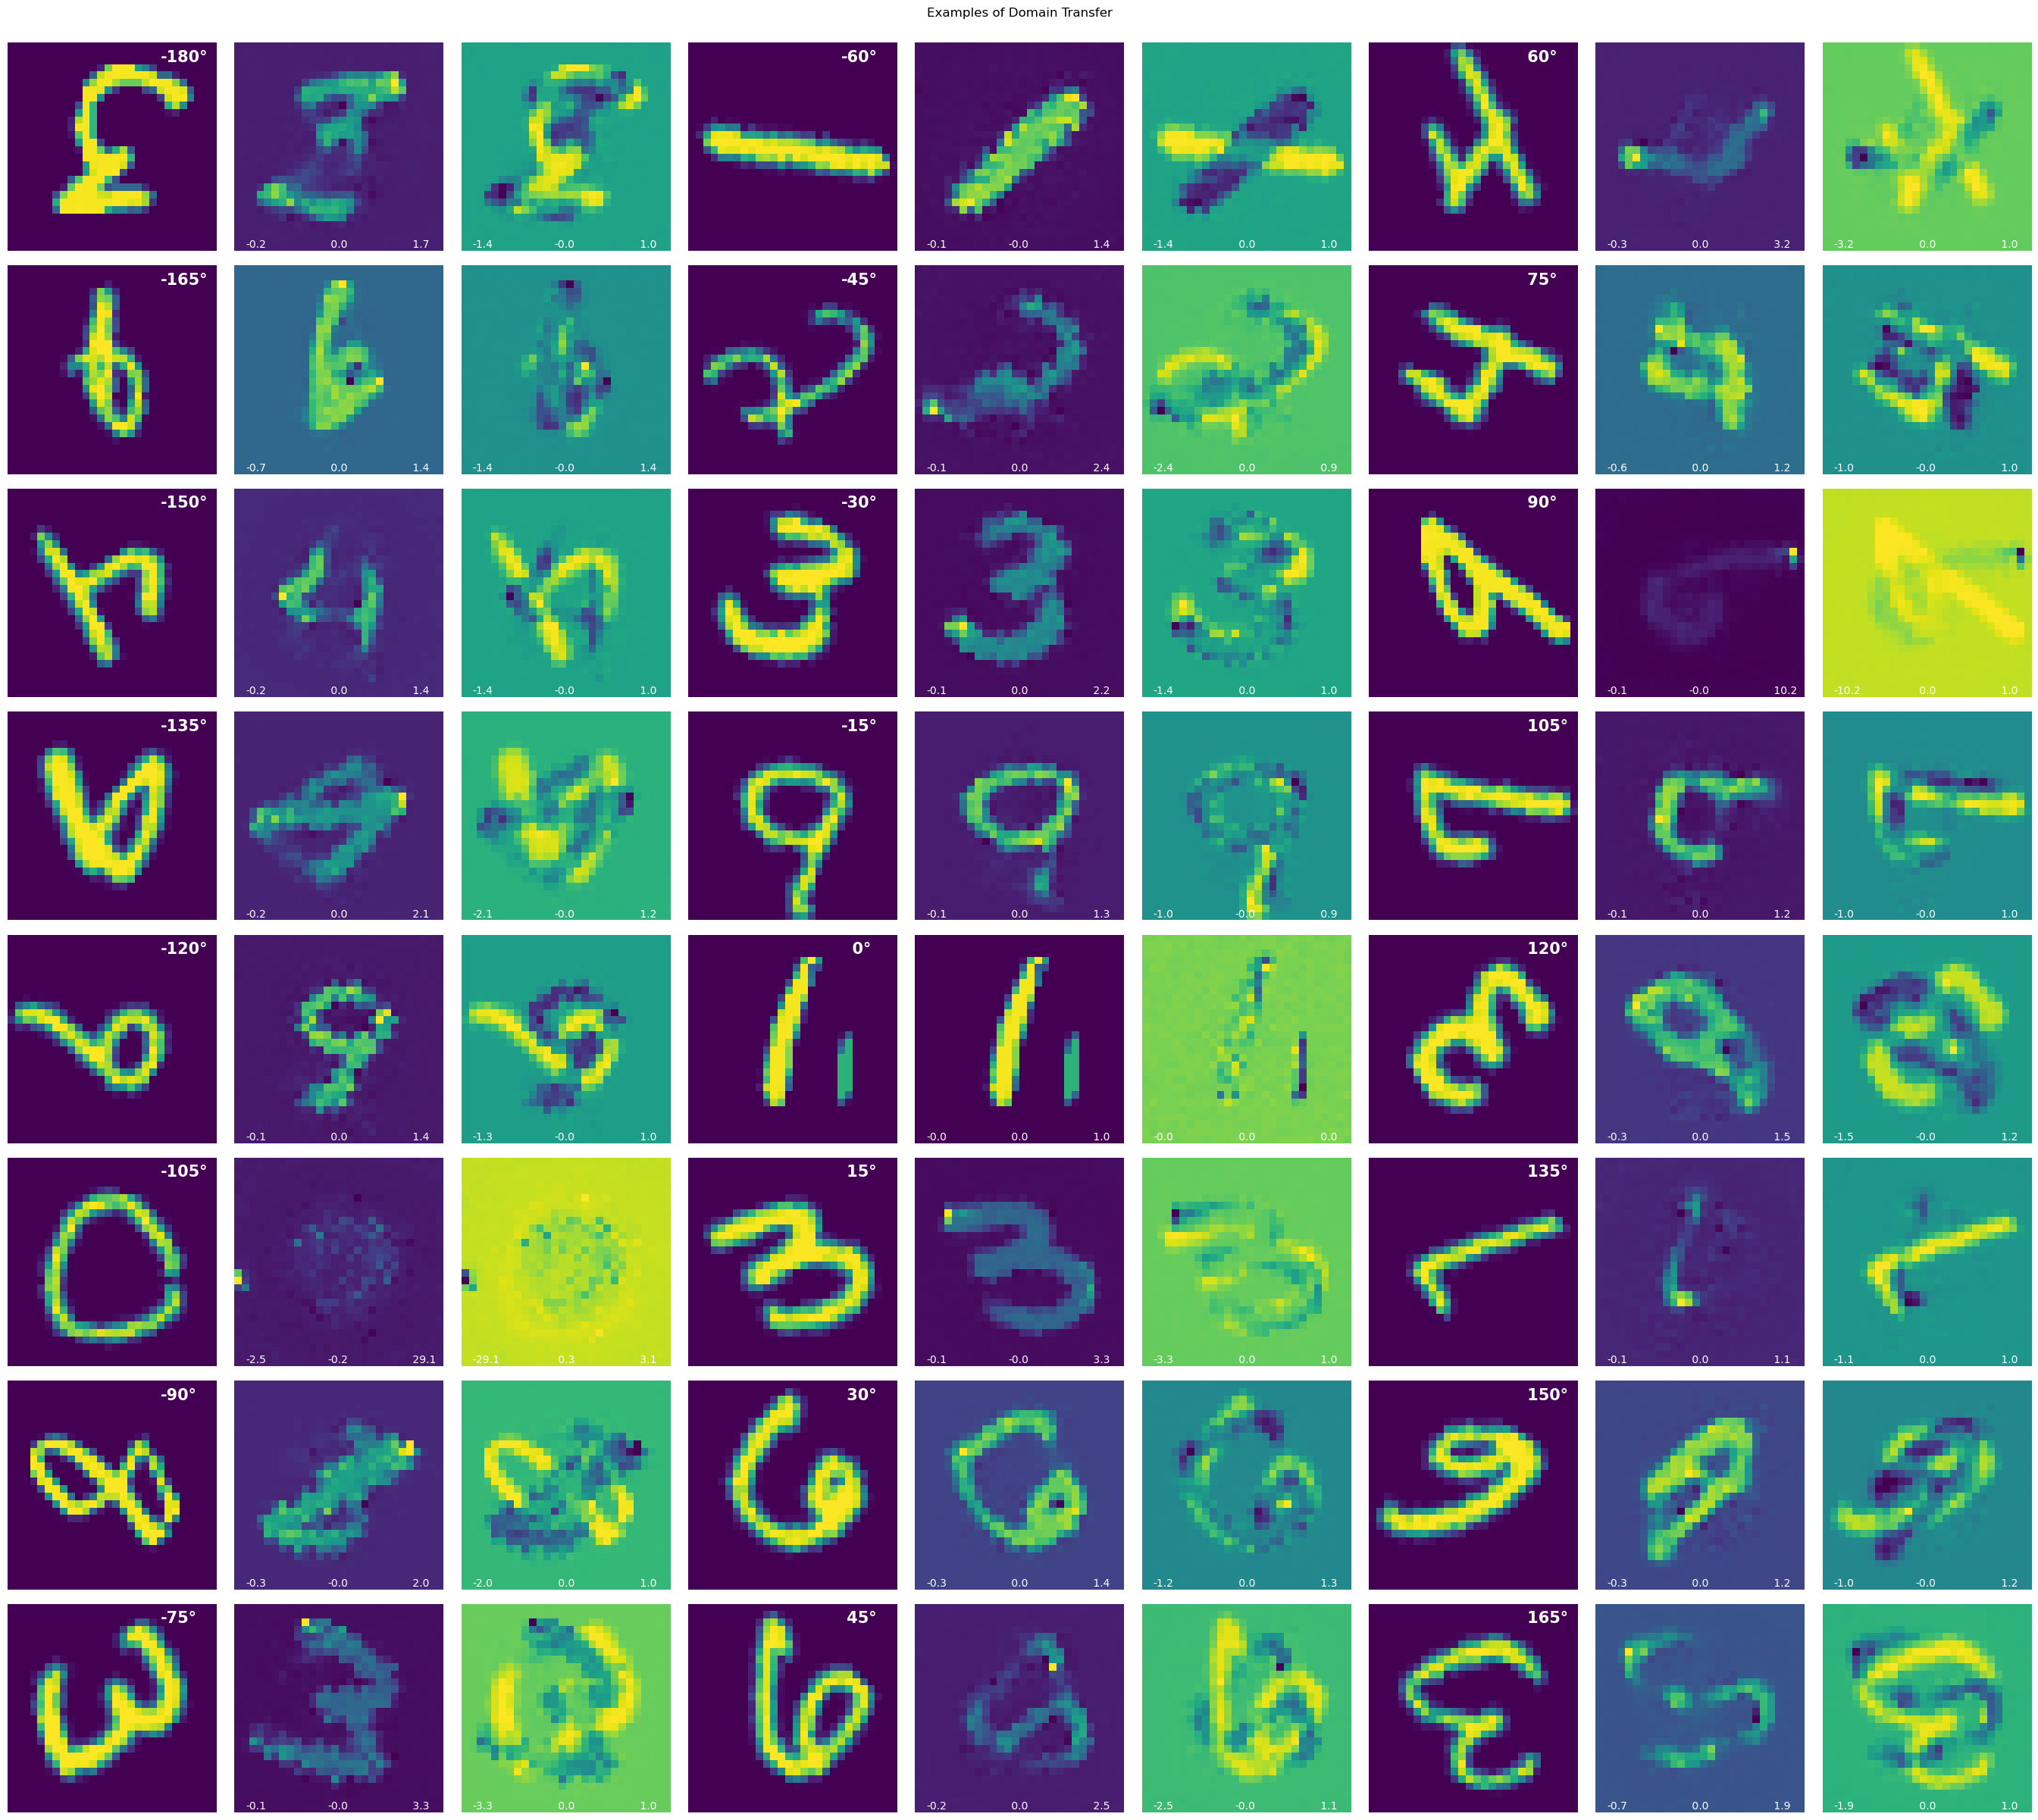

In [117]:
angles = torch.tensor(range(-180, 180, 15))
drot, drec = domain_transfer(cinn, data[:360//15], targets[:360//15], angles)

plot_transfer_image(drot, drec, angles)

In [115]:
N = len(angles)
print(N)
np.array([3*((i*3)%N + (i*3)//N) for i in range(N)]).reshape((8, 3))

24


array([[ 0,  9, 18],
       [27, 36, 45],
       [54, 63,  3],
       [12, 21, 30],
       [39, 48, 57],
       [66,  6, 15],
       [24, 33, 42],
       [51, 60, 69]])

In [94]:
np.array([[(i+3*j)%5 for i in range(3)] for j in range(5)])

array([[0, 1, 2],
       [3, 4, 0],
       [1, 2, 3],
       [4, 0, 1],
       [2, 3, 4]])

In [68]:
def plot_transfer_loss(model:Rotated_cINN, data:torch.Tensor, targets:torch.Tensor, interval:int, train_domains=None, test_domains=None):
    """
    Arguments
    ---------
    model : Rotated_cINN
    data : torch.Tensor, shape=(N, H, W)
    targets : torch.Tensor, shape=(N, 12)
    interval : int, number of degrees between each bar


    N = number of images to average over
    A = N // interval, number of angles for whicht to to calculate a loss
    H, W = height and width of image
    """
    
    degree_range = np.array(range(-179, 181, interval))
    A = len(degree_range)
    transfer_losses = np.zeros(A)
    
    for i, degree in enumerate(degree_range):
        with torch.no_grad():
            print(f"\r    calculating loss for {degree}°", end=" ")
            degrees = degree * torch.ones(len(data))
            
            data_rotated, data_reconstructed = domain_transfer(model, data, targets, degrees)

            l1_loss = torch.mean(torch.abs(data_rotated - data_reconstructed))
            transfer_losses[i] = l1_loss.detach().numpy()
    print("\r")


    plt.figure(figsize=(15, 3))
    plt.bar(degree_range, transfer_losses, width=interval)
    if train_domains != None:
        i_train = np.argwhere((degree_range[:, None] == np.array(train_domains)[None]).any(1))[:,0]
        plt.bar(degree_range[i_train], transfer_losses[i_train], width=interval, label='training domains')
    if test_domains != None:
        i_test = np.argwhere((degree_range[:, None] == np.array(test_domains)[None]).any(1))[:,0]
        plt.bar(degree_range[i_test], transfer_losses[i_test], width=interval, color="red", label="test domains")

    plt.legend()
    plt.xlabel("rotation angle [°]")
    plt.ylabel("mean(abs(rotated - reconstructed))")
    plt.title("L1 loss of domain transfer")
    plt.show()

In [59]:
r = np.arange(-10, 10)
d = np.array([1, 3, 9])
np.argwhere((np.array(r)[None] == np.array(d)[:, None]).any(0))[:,0]
#np.argwhere(np.array(r) == np.array(d))


array([11, 13, 19])

[36 45 54]
[-180 -175 -170 -165 -160 -155 -150 -145 -140 -135 -130 -125 -120 -115
 -110 -105 -100  -95  -90  -85  -80  -75  -70  -65  -60  -55  -50  -45
  -40  -35  -30  -25  -20  -15  -10   -5    0    5   10   15   20   25
   30   35   40   45   50   55   60   65   70   75   80   85   90   95
  100  105  110  115  120  125  130  135  140  145  150  155  160  165
  170  175]


<BarContainer object of 3 artists>

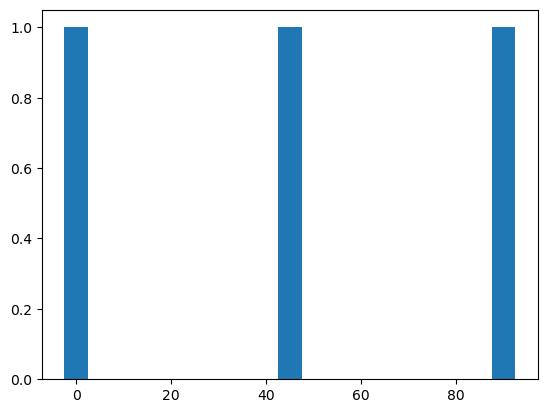

In [60]:
degree_range = np.array(range(-180, 180, 5))
train_domains = [-23, 0, 23, 45, 90, 180]
i_train = np.argwhere((np.array(degree_range)[:, None] == np.array(train_domains)[None]).any(1))[:,0]
transfer_losses = np.ones_like(degree_range)
print(i_train)
print(degree_range)
plt.bar(degree_range[i_train], transfer_losses[i_train], width=5, label='training domains')
    

    calculating loss for 180°  


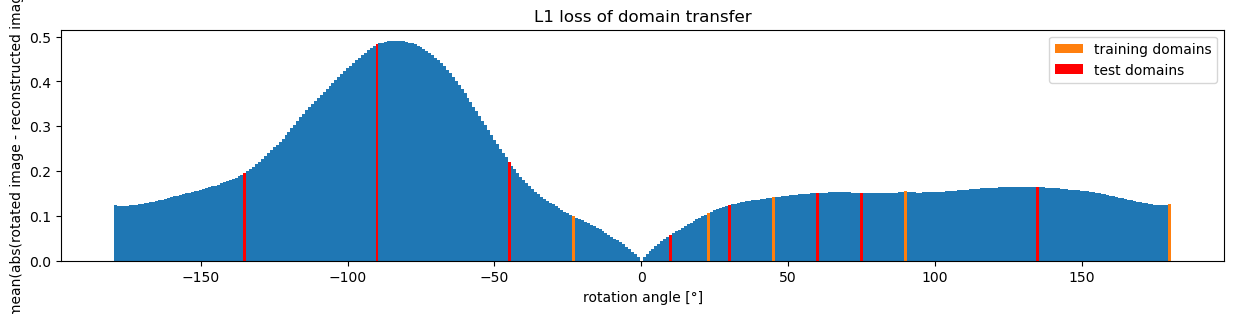

In [67]:
train_domains = [-23, 0, 23, 45, 90, 180]
test_domains  = [-135, -90, -45, 10, 30, 60, 75, 135]
plot_transfer_loss(cinn, data, targets, 1, train_domains, test_domains)

In [18]:
cos, sin = targets_rotated[:, 0], targets_rotated[:, 1]
print(cos.min(), cos.max())
print(sin.min(), sin.max())


tensor(-0.9998) tensor(-0.9998)
tensor(0.0175) tensor(0.0175)


tensor([1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])
tensor([-0.9962,  0.0872,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000])


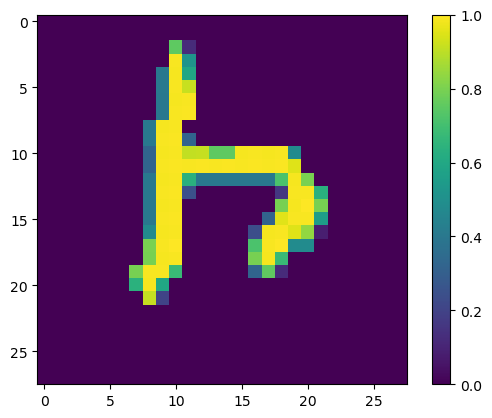

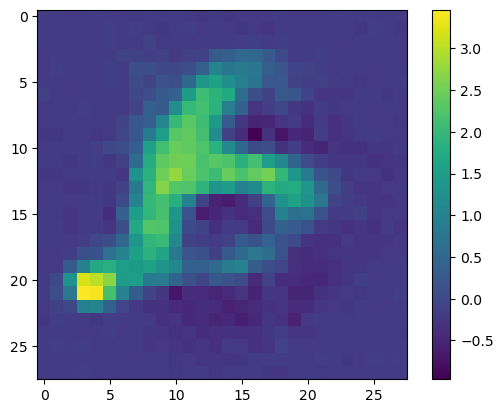

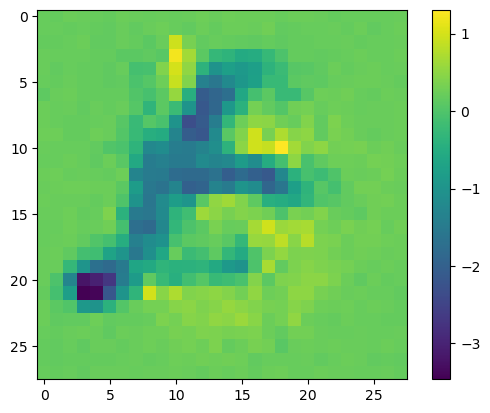

In [40]:
def show(tensor):
    plt.imshow(tensor.detach().numpy())
    plt.colorbar()
    plt.show()

print(targets[45])
print(targets_rotated[45])
index = 2
show(data_rotated[index])
show(data_reconstructed[index])
show(data_rotated[index] - data_reconstructed[index])

In [5]:
from torchvision.transforms.functional import rotate
from torchvision.transforms import RandomRotation

In [6]:
data.shape
angle = 45
angle_sequence = torch.tensor(range(100)).unsqueeze(1).expand((100, 2))
print(angle_sequence.shape)
rot = RandomRotation((angle, angle))
test = rotate(data[angle][None], angle)
#test = RandomRotation(angle_sequence)(data)
test.shape

torch.Size([100, 2])


torch.Size([1, 28, 28])

In [8]:
data_rot = torch.cat([rotate(data[angle][None], angle, fill=float(data.min()))  for angle in range(100)], dim=0)
data_rot.shape

torch.Size([100, 28, 28])

In [11]:
data_rot[0, 0, 0] == data[0,0,0]

tensor(True)

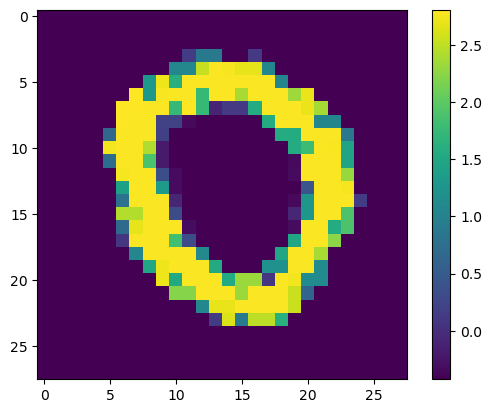

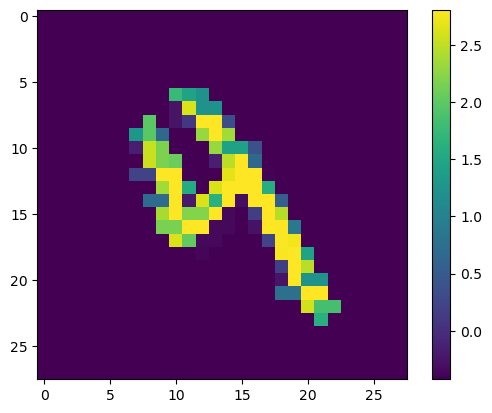

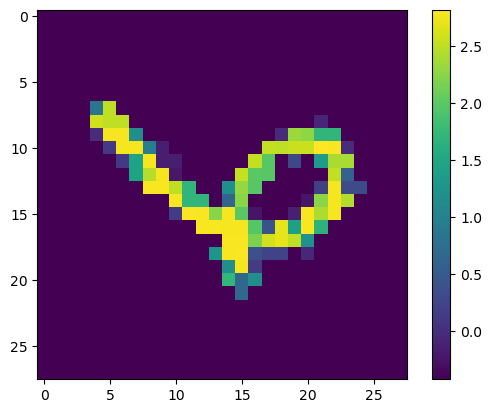

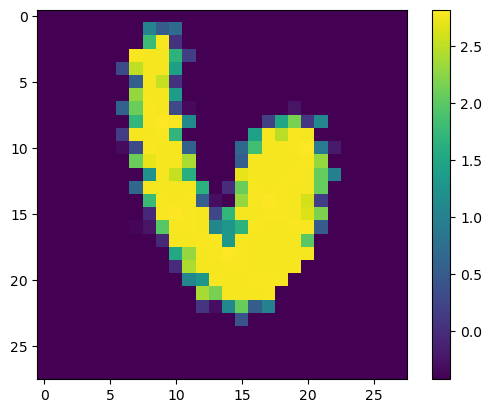

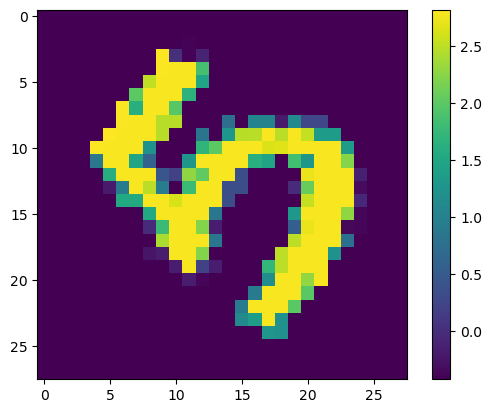

In [9]:
for i in range(50,55):
    plt.imshow(data_rot[i].detach().numpy())
    plt.colorbar()
    plt.show()